In [1]:
# default_exp inferno

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# INFERNO loss

> API details.

In [3]:
#hide
from nbdev.showdoc import *

In [4]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *

from fastcore.all import partialler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict
from fastcore.all import store_attr
from abc import abstractmethod

import torch.nn.functional as F
from torch import optim, autograd, nn, Tensor
import torch
from torch.distributions import Normal

# Network

In [5]:
bs = 2000
data, test = get_paper_data(200000, bs=bs, n_test=1000000)

In [6]:
# export
class VariableSoftmax(nn.Softmax):
    def __init__(self, temp:float=1, dim:int=-1):
        super().__init__(dim=dim)
        self.temp = temp
        
    def forward(self, x:Tensor) -> Tensor: return super().forward(x/self.temp)

In [7]:
x = torch.randn((1,10))

In [8]:
VariableSoftmax(0.1)(x), VariableSoftmax(0.5)(x), VariableSoftmax(1)(x)

(tensor([[3.3334e-09, 1.0929e-18, 1.9934e-10, 2.2358e-14, 9.8467e-10, 1.0588e-19,
          7.4223e-13, 8.2312e-10, 1.0000e+00, 4.1304e-14]]),
 tensor([[1.8830e-02, 2.3878e-04, 1.0720e-02, 1.7385e-03, 1.4755e-02, 1.4971e-04,
          3.5026e-03, 1.4236e-02, 9.3386e-01, 1.9655e-03]]),
 tensor([[0.0847, 0.0095, 0.0639, 0.0257, 0.0749, 0.0075, 0.0365, 0.0736, 0.5962,
          0.0274]]))

In [9]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)

# Loss

In [10]:
x,y,w = next(iter(data.trn_dl))
preds = net(x)
assert preds.shape == (bs,10)

In [11]:
def to_shape(p:Tensor) -> Tensor:
    f = p.sum(0)
    f = f/f.sum()
    return f

In [12]:
m = y.squeeze()==0
f_s = to_shape(preds[~m])
f_b = to_shape(preds[m])

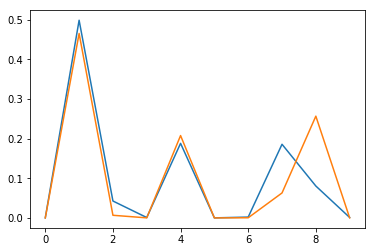

In [13]:
plt.plot(to_np(f_s))
plt.plot(to_np(f_b))

## Minimise width

with torch.no_grad():
    u,d = [],[]
    b = x[m]
    b[:,0] += 0.2
    u.append(to_shape(net(b)))
    b[:,0] -= 0.2
    b[:,2] *= 3.5/3
    u.append(to_shape(net(b)))
    b[:,2] /= 3.5/3
    b[:,0] -= 0.2
    d.append(to_shape(net(b)))
    b[:,0] += 0.2
    b[:,2] *= 2.5/3
    d.append(to_shape(net(b)))
    b[:,2] /= 2.5/3
    b_up,b_dw = torch.stack(u),torch.stack(d)

nll,alpha = calc_profile(f_s=f_s, f_b_nom=f_b, f_b_up=b_up, f_b_dw=b_dw, verbose=False, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

nll

plot_likelihood(to_np(nll-nll[nll==nll].min()))

nll = nll-nll[nll==nll].min()-0.5

nll

plot_likelihood(to_np(nll))

nll.max()-nll.min()

def get_diff_width(nll:Tensor, mu_scan:np.ndarray) -> Tensor:
    def lin_root(nll0,nll1,mu0,mu1):
        a = (nll1-nll0)/(mu1-mu0)
        b = nll1-(a*mu1)
        return -b/a
    
    u,r,last_mu,last_nll = True,torch.zeros((2)),mu_scan[0],nll[0]

    for mu,l in zip(mu_scan[1:],nll[1:]):
        if u and l < 0:
            r[0] = lin_root(last_nll,l,last_mu,mu)
            u = False
        elif not u and l > 0:
            r[1] = lin_root(last_nll,l,last_mu,mu)
            break
        if l == l: last_mu,last_nll = mu,l
    return r[1]-r[0]

w = get_diff_width(nll, mu_scan=np.linspace(20,80,61)); w

class AbsInferno(AbsCallback):
    def __init__(self, n:int, mu_scan:Tensor, true_mu:int, n_steps:int=100, lr:float=0.1):
        super().__init__()
        store_attr()
        
    def on_train_begin(self) -> None:
        r'''
        Fake loss function, callback computes loss in `on_forwards_end`
        '''
        self.wrapper.loss_func = lambda x,y: None
        self.profiler = partialler(calc_profile, n=self.n, mu_scan=to_device(self.mu_scan, self.wrapper.device), true_mu=self.true_mu,
                                   n_steps=self.n_steps, lr=self.lr, verbose=False)
        
    @staticmethod
    def _to_shape(p:Tensor) -> Tensor:
        f = p.sum(0)
        f = f + 1e-7
        f = f/f.sum()
        return f
    
    @abstractmethod
    def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]: pass
        
    def _get_diff_width(self, nll:Tensor) -> Tensor:
        def lin_root(nll0,nll1,mu0,mu1):
            a = (nll1-nll0)/(mu1-mu0)
            b = nll1-(a*mu1)
            return -b/a

        u,r,last_mu,last_nll = True,torch.zeros((2)),self.mu_scan[0],nll[0]
        for mu,l in zip(self.mu_scan[1:],nll[1:]):
            if u and l < 0:
                r[0] = lin_root(last_nll,l,last_mu,mu)
                u = False
            elif not u and l > 0:
                r[1] = lin_root(last_nll,l,last_mu,mu)
                break
            if l == l: last_mu,last_nll = mu,l
        return r[1]-r[0]
        
    def on_forwards_end(self) -> None:
        # Get sig. & bkg. shapes
        b = self.wrapper.y.squeeze()==0
        f_s = self._to_shape(self.wrapper.y_pred[~b])
        f_b = self._to_shape(self.wrapper.y_pred[b])
        f_b_up,f_b_dw = self._get_up_down(self.wrapper.x[b])
        
        # Compute nll
        nll,_ = self.profiler(f_s=f_s, f_b_nom=f_b, f_b_up=f_b_up, f_b_dw=f_b_dw)
        try: nll = nll-nll[nll==nll].min()-0.5
        except RuntimeError: print(nll, self.wrapper.y_pred)
        w = self._get_diff_width(nll)
        print(w)
        print(self.wrapper.model[4].weight)
        self.wrapper.loss_val = torch.clamp_min(w, 0)

class PaperInferno(AbsInferno):
    def __init__(self, n:int=1050, mu_scan:Tensor=torch.linspace(20,80,61), true_mu:int=50, n_steps:int=100, lr:float=0.1):
        super().__init__(n=n, mu_scan=mu_scan, true_mu=true_mu, n_steps=n_steps, lr=lr)
    
    def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]:
        with torch.no_grad():
            u,d = [],[]
            x[:,0] += 0.2
            u.append(self._to_shape(self.wrapper.model(x)))
            x[:,0] -= 0.2
            x[:,2] *= 3.5/3
            u.append(self._to_shape(self.wrapper.model(x)))
            x[:,2] /= 3.5/3
            x[:,0] -= 0.2
            d.append(self._to_shape(self.wrapper.model(x)))
            x[:,0] += 0.2
            x[:,2] *= 2.5/3
            d.append(self._to_shape(self.wrapper.model(x)))
            x[:,2] /= 2.5/3
            return torch.stack(u),torch.stack(d)

net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=nn.BCELoss(),
          cbs=[PaperInferno(),LossTracker(),EarlyStopping(5),GradClip(1e-5)])

model.save('weights/Inferno_Test.h5')

In [14]:
class AbsInferno(AbsCallback):
    def __init__(self, n:int, mu_scan:Tensor, true_mu:float, aug_alpha:bool=False, n_alphas:int=0, n_steps:int=100, lr:float=0.1):
        super().__init__()
        store_attr()
        
    def on_train_begin(self) -> None:
        self.wrapper.loss_func = None  # Ensure loss function is skipped, callback computes loss value in `on_forwards_end`
        for c in self.wrapper.cbs:
            if hasattr(c, 'loss_is_meaned'): c.loss_is_meaned = False  # Ensure that average losses are correct
    
    @staticmethod
    def to_shape(p:Tensor) -> Tensor:
        f = p.sum(0)+1e-7
        return f/f.sum()
        
    @abstractmethod
    def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]: pass
    
    def get_ikk(self, f_s:Tensor, f_b_nom:Tensor, f_b_up:Tensor, f_b_dw:Tensor) -> Tensor:       
        if self.aug_alpha: alpha = torch.randn((self.n_alphas+1), requires_grad=True, device=self.wrapper.device)
        else:              alpha = torch.zeros((self.n_alphas+1), requires_grad=True, device=self.wrapper.device)
        with torch.no_grad():
            alpha /= 10
            alpha[0] += self.true_mu
        get_nll = partialler(calc_nll, s_true=self.true_mu, b_true=self.n-self.true_mu,
                             f_s=f_s, f_b_nom=f_b_nom[None,:], f_b_up=f_b_up, f_b_dw=f_b_dw)
        if self.aug_alpha:  # Alphas carry noise, optimise via Newton
            for i in range(self.n_steps):  # Newton optimise nuisances & mu
                nll = get_nll(s_exp=alpha[0], alpha=alpha[1:])
                g,h = calc_grad_hesse(nll, alpha)
                s = torch.clamp(self.lr*g.detach()@torch.inverse(h), -100, 100)
                alpha = alpha-s
        nll = get_nll(s_exp=alpha[0], alpha=alpha[1:])
        _,h = calc_grad_hesse(nll, alpha, create_graph=True)
        ikk = torch.inverse(h)[0,0]
        return ikk
        
    def on_forwards_end(self) -> None:
        
    
        b = self.wrapper.y.squeeze() == 0
        f_s = to_shape(self.wrapper.y_pred[~b])
        f_b = to_shape(self.wrapper.y_pred[b])
        f_b_up,f_b_dw = self._get_up_down(self.wrapper.x[b])
        self.wrapper.loss_val = self.get_ikk(f_s=f_s, f_b_nom=f_b, f_b_up=f_b_up, f_b_dw=f_b_dw)

In [15]:
class PaperInferno(AbsInferno):
    def __init__(self, r_mods:Optional[Tuple[float,float]]=(-0.2,0.2), l_mods:Optional[Tuple[float,float]]=(2.5,3.5), l_init:float=3,
                 n:int=1050, mu_scan:Tensor=torch.linspace(20,80,61), true_mu:int=50, aug_alpha:bool=False, n_steps:int=10, lr:float=0.1):
        super().__init__(n=n, mu_scan=mu_scan, true_mu=true_mu, aug_alpha=aug_alpha, n_alphas=(r_mods is not None)+(l_mods is not None), n_steps=n_steps, lr=lr)
        self.r_mods,self.l_mods,self.l_init = r_mods,l_mods,l_init
        
    def on_train_begin(self) -> None:
        if self.r_mods is not None:
            self.r_mod_t = (torch.zeros(1,3, device=self.wrapper.device),torch.zeros(1,3, device=self.wrapper.device))
            self.r_mod_t[0][0,0] = self.r_mods[0]
            self.r_mod_t[1][0,0] = self.r_mods[1]
        if self.l_mods is not None:
            self.l_mod_t = (torch.ones(1,3, device=self.wrapper.device),torch.ones(1,3, device=self.wrapper.device))
            self.l_mod_t[0][0,2] = self.l_mods[0]/self.l_init
            self.l_mod_t[1][0,2] = self.l_mods[1]/self.l_init
    
    def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]:
        if self.r_mods is None and self.l_mods is None: return None,None
        u,d = [],[]
        if self.r_mods is not None:
            x = x+self.r_mod_t[0]
            d.append(self.to_shape(self.wrapper.model(x)))
            x = x+self.r_mod_t[1]-self.r_mod_t[0]
            u.append(self.to_shape(self.wrapper.model(x)))
            x = x-self.r_mod_t[1]
        if self.l_mods is not None:
            x = x*self.l_mod_t[0]
            d.append(self.to_shape(self.wrapper.model(x)))
            x = x*self.l_mod_t[1]/self.l_mod_t[0]
            u.append(self.to_shape(self.wrapper.model(x)))
            x = x/self.l_mod_t[1]
        return torch.stack(u),torch.stack(d)

In [7]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)

In [16]:
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=None,
          cbs=[PaperInferno(aug_alpha=True, n_steps=10),LossTracker(),SaveBest('weights/best_ii2a.h5'),EarlyStopping(10)])

1: Train=693.5617352294922 Valid=601.9784533691407
2: Train=562.329810180664 Valid=530.5830700683593
3: Train=499.61959350585937 Valid=490.6258813476563
4: Train=465.72738494873045 Valid=461.51154357910156
5: Train=438.92813385009765 Valid=457.37815063476563
6: Train=426.3840362548828 Valid=427.2156604003906
7: Train=412.44627075195314 Valid=418.5536254882812
8: Train=401.3213714599609 Valid=410.15827514648436
9: Train=393.9960906982422 Valid=403.7965435791016
10: Train=387.0268667602539 Valid=393.75219299316404
11: Train=377.73050079345705 Valid=386.5479626464844
12: Train=370.2349505615234 Valid=377.8233563232422
13: Train=363.31306701660156 Valid=369.7464886474609
14: Train=354.7260543823242 Valid=359.86211181640624
15: Train=346.4808587646484 Valid=351.27724365234377
16: Train=341.5829052734375 Valid=348.709755859375
17: Train=336.47557342529296 Valid=343.7917321777344
18: Train=332.64031188964844 Valid=339.3718115234375
19: Train=328.40007278442386 Valid=336.5342205810547
20: Trai

In [17]:
model.save('weights/Inferno_Test_interp_bm2a.h5')

In [8]:
model.load('weights/Inferno_Test_interp_bm2a.h5')

# Results

In [9]:
# export
class InfernoPred(PredHandler):
    def get_preds(self) -> np.ndarray: return np.argmax(self.preds, 1)#/len(self.wrapper.model[-2].weight)

## BM 0

In [10]:
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [11]:
df = pd.DataFrame({'pred':preds})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,6,1.0
1,1,1.0
2,8,1.0
3,2,1.0
4,8,1.0


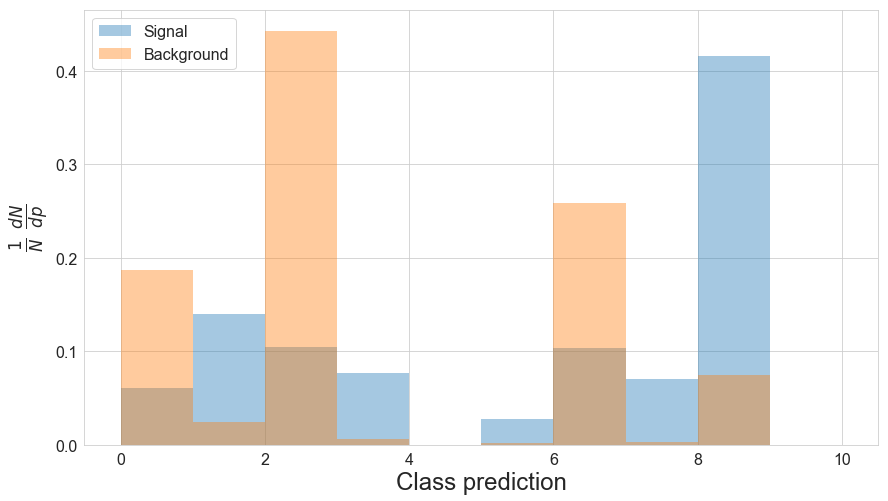

In [21]:
plot_preds(df, bin_edges=np.linspace(0,10,11))

In [12]:
bin_preds(df)

In [23]:
df.head()

,pred,gen_target,pred_bin
0,8,1.0,8
1,8,1.0,8
2,2,1.0,2
3,1,1.0,1
4,8,1.0,8


In [13]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [25]:
f_s.sum(), f_b.sum()

(tensor(1.0000), tensor(1.))

In [26]:
f_s, f_b

(tensor([6.1256e-02, 1.4035e-01, 1.0485e-01, 7.6594e-02, 2.0000e-13, 2.7264e-02,
         1.0357e-01, 7.0516e-02, 4.1560e-01, 2.0000e-13]),
 tensor([1.8722e-01, 2.3994e-02, 4.4317e-01, 6.5920e-03, 2.0000e-13, 2.2320e-03,
         2.5882e-01, 3.1320e-03, 7.4836e-02, 2.0000e-13]))

In [27]:
asimov = (50*f_s)+(1000*f_b)

In [28]:
asimov, asimov.sum()

(tensor([1.9028e+02, 3.1012e+01, 4.4842e+02, 1.0422e+01, 2.1000e-10, 3.5952e+00,
         2.6400e+02, 6.6578e+00, 9.5616e+01, 2.1000e-10]), tensor(1050.))

In [29]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([24.70436096, 24.55772781, 24.41741753, 24.28354836, 24.15490913,
       24.03219604, 23.91545105, 23.80406761, 23.69872665, 23.59823418,
       23.50326157, 23.41361618, 23.32941246, 23.249897  , 23.17568207,
       23.10615349, 23.04220963, 22.98236084, 22.92743301, 22.87781525,
       22.83231163, 22.79160309, 22.75542068, 22.72370529, 22.69625473,
       22.67327881, 22.65443039, 22.63990784, 22.62975883, 22.6236515 ,
       22.62175179, 22.62364197, 22.62961006, 22.63937187, 22.65359879,
       22.67119598, 22.6928997 , 22.71788406, 22.74727821, 22.77983475,
       22.816082  , 22.85604286, 22.89976311, 22.94672775, 22.99706078,
       23.0510788 , 23.10885429, 23.16915131, 23.2332592 , 23.30097961,
       23.37120819, 23.44538307, 23.52247047, 23.60282135, 23.68608856,
       23.77264786, 23.86260223, 23.95517921, 24.05083084, 24.14945221,
       24.25124168])

In [30]:
y_tf2 = np.array([31.626238,31.466385,31.313095,31.166267,31.025808,30.891619,30.76361
,30.641693,30.525778,30.415783,30.31162,30.213215,30.120483,30.033348
,29.951736,29.875574,29.804789,29.739307,29.679066,29.623993,29.574026
,29.5291,29.489151,29.454117,29.423939,29.398558,29.377914,29.361954
,29.35062,29.343859,29.341618,29.343842,29.350483,29.36149,29.376812
,29.396404,29.420216,29.448202,29.480318,29.516518,29.556757,29.600994
,29.649185,29.70129,29.757267,29.817076,29.88068,29.948036,30.019108
,30.093859,30.17225,30.25425,30.339819,30.42892,30.521524,30.617598
,30.7171,30.820007,30.926281,31.035892,31.148808], dtype='float32')

In [31]:
y_tf2-y_tf2.min()

array([2.2846203e+00, 2.1247673e+00, 1.9714775e+00, 1.8246498e+00,
       1.6841908e+00, 1.5500011e+00, 1.4219933e+00, 1.3000755e+00,
       1.1841602e+00, 1.0741653e+00, 9.7000313e-01, 8.7159729e-01,
       7.7886581e-01, 6.9173050e-01, 6.1011887e-01, 5.3395653e-01,
       4.6317101e-01, 3.9768982e-01, 3.3744812e-01, 2.8237534e-01,
       2.3240852e-01, 1.8748283e-01, 1.4753342e-01, 1.1249924e-01,
       8.2321167e-02, 5.6940079e-02, 3.6296844e-02, 2.0336151e-02,
       9.0026855e-03, 2.2411346e-03, 0.0000000e+00, 2.2239685e-03,
       8.8653564e-03, 1.9872665e-02, 3.5194397e-02, 5.4786682e-02,
       7.8598022e-02, 1.0658455e-01, 1.3870049e-01, 1.7490005e-01,
       2.1513939e-01, 2.5937653e-01, 3.0756760e-01, 3.5967255e-01,
       4.1564941e-01, 4.7545815e-01, 5.3906250e-01, 6.0641861e-01,
       6.7749023e-01, 7.5224113e-01, 8.3063316e-01, 9.1263199e-01,
       9.9820137e-01, 1.0873032e+00, 1.1799068e+00, 1.2759800e+00,
       1.3754826e+00, 1.4783897e+00, 1.5846634e+00, 1.6942749e

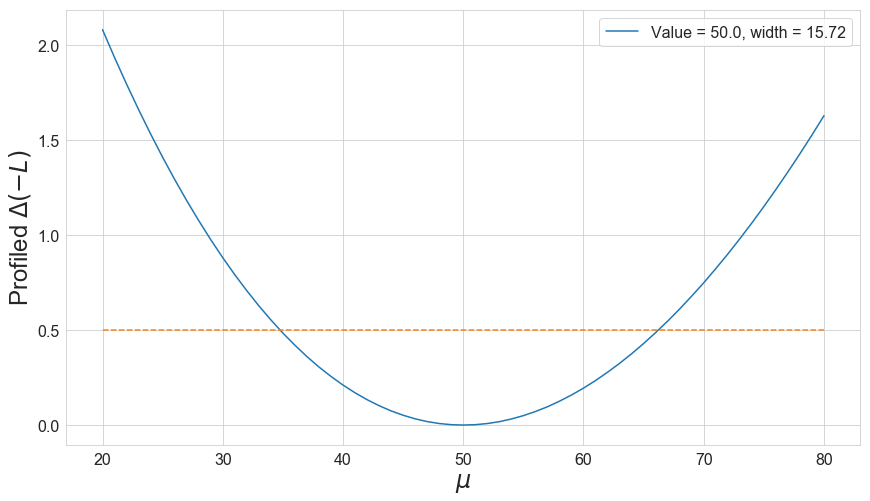

In [32]:
plot_likelihood(y-y.min())

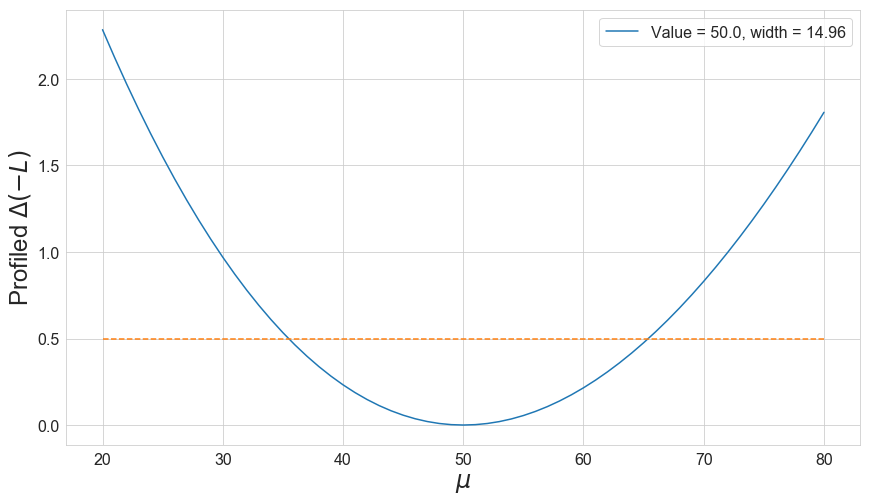

In [33]:
plot_likelihood(y_tf2-y_tf2.min())

# Nuisances - via interpolation

In [14]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [15]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [36]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,8,1.0,8,8,8,8,8,8,8,8,8,8,8
1,8,1.0,8,8,8,8,8,8,8,8,8,8,8
2,2,1.0,2,2,2,2,2,2,2,2,2,2,2
3,1,1.0,1,1,1,1,1,1,1,1,1,1,1
4,8,1.0,8,8,8,8,8,8,8,8,8,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2,0.0,2,2,2,2,2,2,2,2,2,2,2
999996,8,0.0,8,8,8,8,8,8,8,8,8,8,8
999997,6,0.0,6,6,6,6,6,6,6,6,6,6,6
999998,2,0.0,2,2,2,2,2,2,2,2,2,2,2


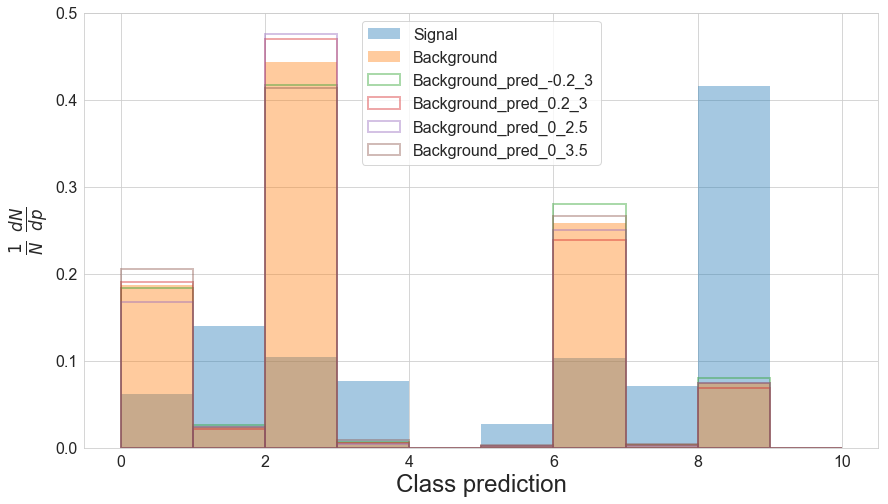

In [37]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

tensor([1.6336e-01, 2.6676e-02, 4.4885e-01, 5.0460e-03, 2.0000e-13, 2.0740e-03,
        2.7156e-01, 2.1760e-03, 8.0248e-02, 2.0000e-13])
tensor([1.8343e-01, 2.6624e-02, 4.1623e-01, 7.1260e-03, 2.0000e-13, 2.5900e-03,
        2.8016e-01, 3.3780e-03, 8.0454e-02, 2.0000e-13])
tensor([2.0132e-01, 2.6444e-02, 3.8668e-01, 9.4040e-03, 2.0000e-13, 3.0560e-03,
        2.8797e-01, 4.8920e-03, 8.0228e-02, 2.0000e-13])
tensor([1.6715e-01, 2.4046e-02, 4.7580e-01, 4.5120e-03, 2.0000e-13, 1.7160e-03,
        2.5022e-01, 1.9300e-03, 7.4630e-02, 2.0000e-13])
tensor([1.8722e-01, 2.3994e-02, 4.4317e-01, 6.5920e-03, 2.0000e-13, 2.2320e-03,
        2.5882e-01, 3.1320e-03, 7.4836e-02, 2.0000e-13])
tensor([2.0510e-01, 2.3814e-02, 4.1363e-01, 8.8700e-03, 2.0000e-13, 2.6980e-03,
        2.6663e-01, 4.6460e-03, 7.4610e-02, 2.0000e-13])
tensor([1.6983e-01, 2.1536e-02, 5.0241e-01, 3.9460e-03, 2.0000e-13, 1.3800e-03,
        2.3032e-01, 1.6480e-03, 6.8928e-02, 2.0000e-13])
tensor([1.8990e-01, 2.1484e-02, 4.6979e-0

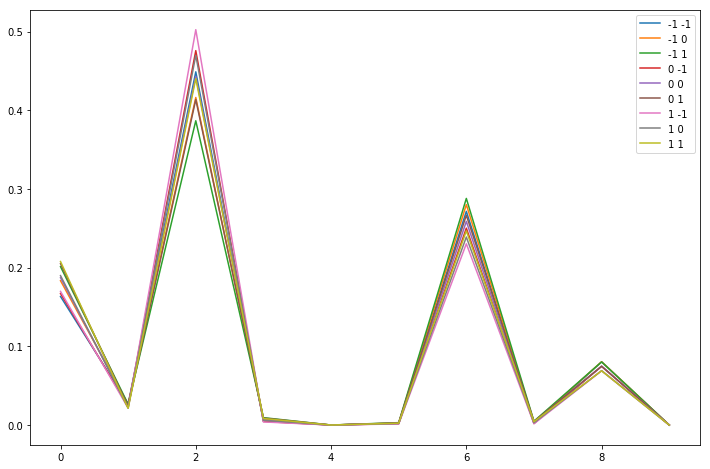

In [38]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        print(s)
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [16]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [40]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [41]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [42]:
nll = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

In [43]:
nll = to_np(nll)

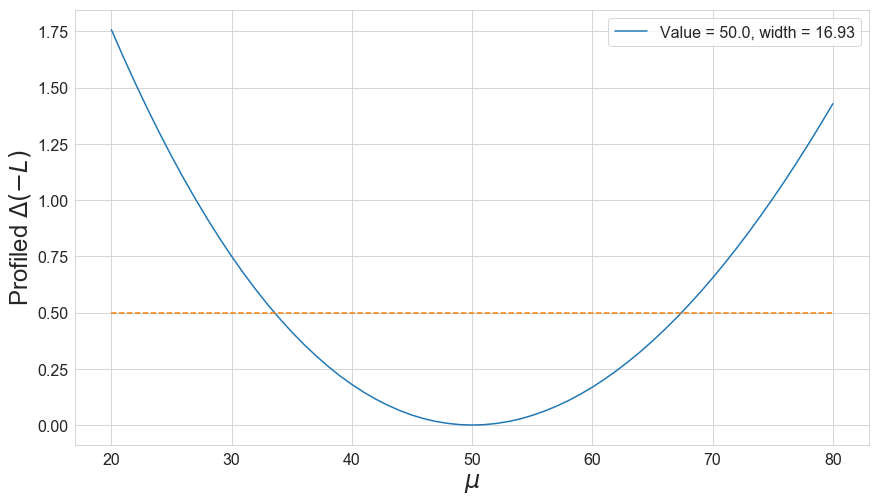

In [44]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [45]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [46]:
nll = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

In [47]:
nll = to_np(nll)

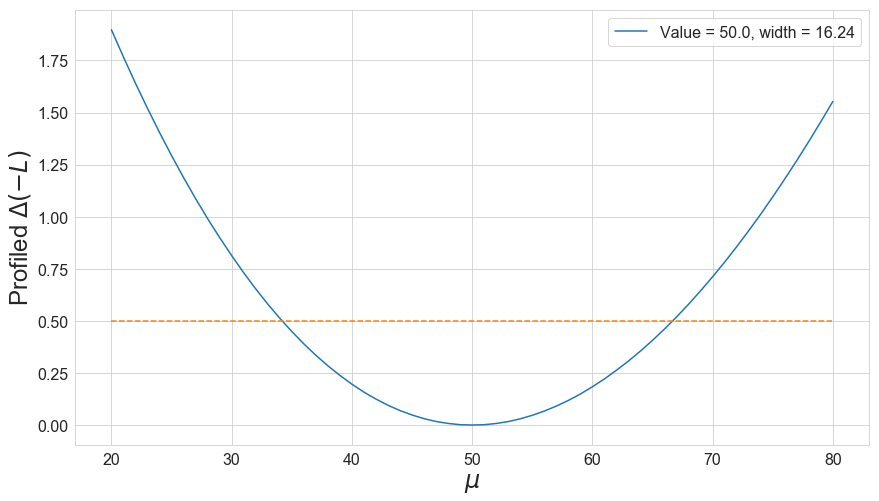

In [48]:
plot_likelihood(nll-nll.min())

## BM 2

In [49]:
nll = profiler(f_s=f_s, n_steps=100, **b_shapes)

In [50]:
nll = to_np(nll)

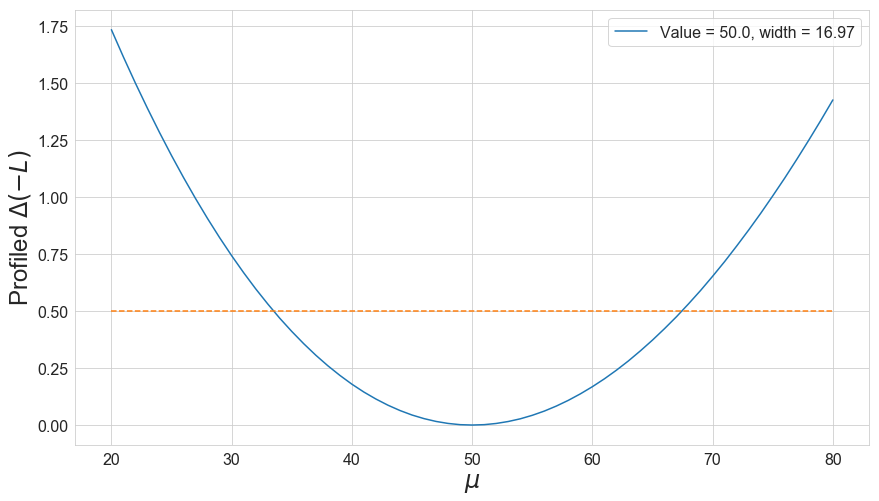

In [51]:
plot_likelihood(nll-nll.min())

## BM 3

In [17]:
alpha_aux = [Normal(0,2), Normal(0,2)]

In [18]:
nll = profiler(f_s=f_s, n_steps=100, alpha_aux=alpha_aux, **b_shapes)

In [19]:
nll = to_np(nll)

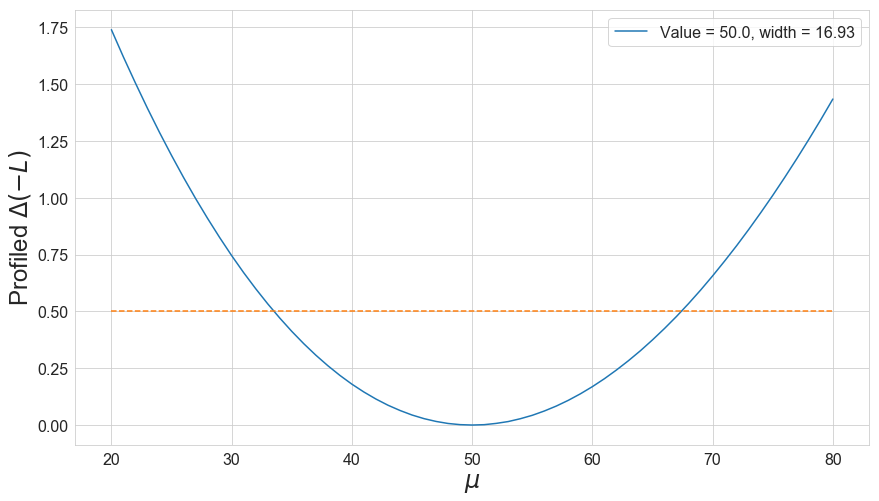

In [20]:
plot_likelihood(nll-nll.min())

## BM 4

In [21]:
alpha_aux = [Normal(0,2), Normal(0,2)]

In [22]:
nll = profiler(f_s=f_s, n_steps=100, alpha_aux=alpha_aux, float_b=True, b_aux=Normal(1000,100), **b_shapes)

Linear regime: Mu 20.0, alpha tensor([-0.3006,  0.1258, 25.4516])
Linear regime: Mu 21.0, alpha tensor([-0.2908,  0.1200, 24.5282])
Linear regime: Mu 22.0, alpha tensor([-0.2809,  0.1142, 23.6106])
Linear regime: Mu 23.0, alpha tensor([-0.2710,  0.1086, 22.6988])
Linear regime: Mu 24.0, alpha tensor([-0.2611,  0.1031, 21.7926])
Linear regime: Mu 25.0, alpha tensor([-0.2512,  0.0978, 20.8920])
Linear regime: Mu 26.0, alpha tensor([-0.2412,  0.0926, 19.9969])
Linear regime: Mu 27.0, alpha tensor([-0.2313,  0.0875, 19.1072])
Linear regime: Mu 28.0, alpha tensor([-0.2213,  0.0825, 18.2229])
Linear regime: Mu 29.0, alpha tensor([-0.2113,  0.0777, 17.3440])
Linear regime: Mu 30.0, alpha tensor([-0.2013,  0.0730, 16.4703])
Linear regime: Mu 31.0, alpha tensor([-0.1913,  0.0684, 15.6017])
Linear regime: Mu 32.0, alpha tensor([-0.1813,  0.0639, 14.7383])
Linear regime: Mu 33.0, alpha tensor([-0.1712,  0.0595, 13.8799])
Linear regime: Mu 34.0, alpha tensor([-0.1612,  0.0552, 13.0265])
Linear reg

In [23]:
nll = to_np(nll)

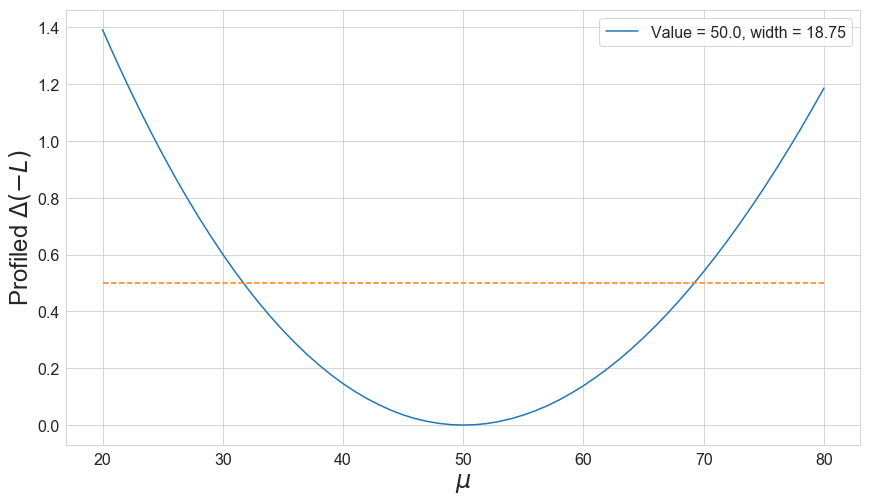

In [24]:
plot_likelihood(nll-nll.min())